In [1]:
%pylab inline
from numpy import linalg as LA
import os
import sklearn.preprocessing as prep
from keras.datasets import mnist
import tensorflow as tf

from sklearn.decomposition import KernelPCA
import seaborn as sns
sns.set_style('white')
sns.set_context('talk', font_scale=2)

def min_max_scale(X):
    preprocessor = prep.MinMaxScaler().fit(X)
    X_scaled = preprocessor.transform(X)
    return X_scaled

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0

In [3]:
config = tf.ConfigProto(
    device_count = {'GPU': 0}
)
config.gpu_options.allocator_type = 'BFC'


In [4]:
class Autoencoder(object):
    def __init__(self, 
                 input_dim, 
                 learning_rate=0.001, 
                 n_latent=8, 
                 batch_size=50):
        self.learning_rate = learning_rate
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.input_dim = input_dim
        
        self._build_network()
        self._create_loss_optimizer()

        
        init = tf.global_variables_initializer()        
        #init = tf.initialize_all_variables()
        # Launch the session
        self.session = tf.InteractiveSession(config=config)
        self.session.run(init)
        self.saver = tf.train.Saver(tf.global_variables())
        
    
    def _build_network(self):        
        self.x = tf.placeholder(tf.float32, [None, self.input_dim])
        dense1 = tf.layers.dense(activation=tf.nn.elu, inputs=self.x, units=256)
        dense2 = tf.layers.dense(activation=tf.nn.elu, inputs=dense1, units=256)
        dense3 = tf.layers.dense(activation=tf.nn.elu, inputs=dense2, units=256)
        self.z = tf.layers.dense(activation=None, inputs=dense3, units=self.n_latent)
        
        ddense1 = tf.layers.dense(activation=tf.nn.elu, inputs=self.z, units=256)
        ddense2 = tf.layers.dense(activation=tf.nn.elu, inputs=ddense1, units=256)
        ddense3 = tf.layers.dense(activation=tf.nn.elu, inputs=ddense2, units=256)

        self.reconstructed = tf.layers.dense(activation=tf.nn.sigmoid, 
                                             inputs=ddense3,
                                             units=self.input_dim)
    
    def _create_loss_optimizer(self):
        self.cost = tf.reduce_mean(tf.square(self.reconstructed - self.x))/self.batch_size
        # ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)         
    
    
    def fit_minibatch(self, batch):
        _, cost = self.session.run([self.optimizer,
                                    self.cost], 
                                   feed_dict = {self.x: batch})
        return  cost
    
    def reconstruct(self, x):
        return self.session.run([self.reconstructed], feed_dict={self.x: x})
    
    def decoder(self, z):
        return self.session.run([self.reconstructed], feed_dict={self.z: z})
    
    def encoder(self, x):
        return self.session.run([self.z], feed_dict={self.x: x})

    def save_model(self, checkpoint_path, epoch):
        self.saver.save(self.session, checkpoint_path, global_step = epoch)

    def load_model(self, checkpoint_path):
        ckpt = tf.train.get_checkpoint_state(checkpoint_path)
        print('loading model: {}'.format(ckpt.model_checkpoint_path))
        self.saver.restore(self.session, checkpoint_path+'/'+ckpt.model_checkpoint_path)

In [5]:
data = x_train
num_sample = x_train.shape[0]
input_dim = 784
learning_rate = 1e-3
batch_size = 100
num_epoch = 50
n_latent = 2 
checkpoint_dir='/Z/personal-folders/interns/saket/mnist_autoencoder_ckpt'
os.makedirs(checkpoint_dir, exist_ok=True)
model = Autoencoder(input_dim=input_dim,
                    learning_rate=learning_rate,
                    n_latent=n_latent,
                    batch_size=batch_size)
total_losses = []

for epoch in range(num_epoch):
    for iter in range(num_sample // batch_size):
        input_batch = data[iter*batch_size: min((iter+1)*batch_size, data.shape[0]),]
        total_loss = model.fit_minibatch(input_batch)
    total_losses.append(total_loss)

    if epoch % 5 == 0:
        print('[Epoch {}] Loss: {}'.format(
            epoch, total_loss))
        checkpoint_path = os.path.join(checkpoint_dir, 'model.ckpt')
        model.save_model(checkpoint_path, epoch)
        print ("model saved to {}".format(checkpoint_path))

print('Done!')

[Epoch 0] Loss: 0.0005190573865547776
model saved to /Z/personal-folders/interns/saket/mnist_autoencoder_ckpt/model.ckpt
[Epoch 5] Loss: 0.0003803625295404345
model saved to /Z/personal-folders/interns/saket/mnist_autoencoder_ckpt/model.ckpt
[Epoch 10] Loss: 0.0003630302380770445
model saved to /Z/personal-folders/interns/saket/mnist_autoencoder_ckpt/model.ckpt
[Epoch 15] Loss: 0.00033139160950668156
model saved to /Z/personal-folders/interns/saket/mnist_autoencoder_ckpt/model.ckpt
[Epoch 20] Loss: 0.00033106832415796816
model saved to /Z/personal-folders/interns/saket/mnist_autoencoder_ckpt/model.ckpt
[Epoch 25] Loss: 0.0003211283765267581
model saved to /Z/personal-folders/interns/saket/mnist_autoencoder_ckpt/model.ckpt
[Epoch 30] Loss: 0.0003202004299964756
model saved to /Z/personal-folders/interns/saket/mnist_autoencoder_ckpt/model.ckpt
[Epoch 35] Loss: 0.0003280583769083023
model saved to /Z/personal-folders/interns/saket/mnist_autoencoder_ckpt/model.ckpt
[Epoch 40] Loss: 0.00031

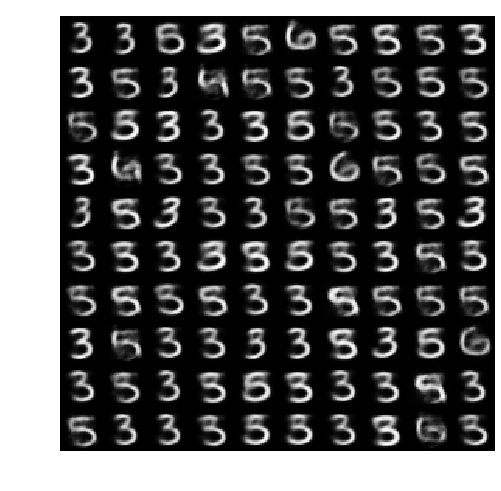

In [6]:
z = np.random.normal(size=[model.batch_size, model.n_latent])
x_generated = model.decoder(z)[0]

w = h = 28
n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))

for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(w, h)

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(I_generated, cmap='gray')


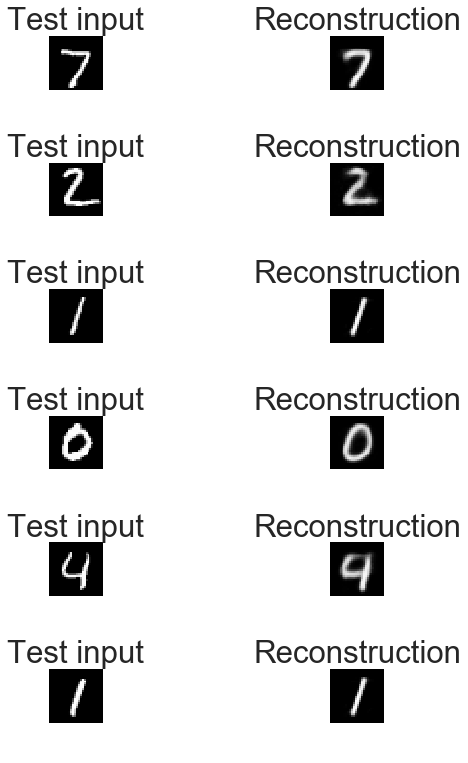

In [7]:
x_sample = x_test
y_sample = y_test
x_reconstruct = model.reconstruct(x_sample)

plt.figure(figsize=(8, 12))

for i in range(6):

    plt.subplot(7, 2, 2*i + 1)
    plt.axis('off')
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    #plt.colorbar()
    plt.subplot(7, 2, 2*i + 2)
    plt.axis('off')
    plt.imshow(x_reconstruct[0][i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    #plt.colorbar()
plt.tight_layout()


In [8]:
reconstructed_autoencoder = model.reconstruct(x_train)[0]


# PCA

In [9]:
x_train_mean = x_train.mean(axis=0)
U, S, V = np.linalg.svd(x_train - x_train_mean, 
                        full_matrices=False)
z_pca = np.dot(x_train - x_train_mean, V.transpose())

reconstructed_pca = np.dot(z_pca[:,:2], V[:2,:]) + x_train_mean
err = (x_train-reconstructed_pca**2).mean(axis=None)
#/reconstructed_pca.shape[0]/reconstructed_pca.shape[1]
print('PCA reconstruction error with 2 PCs: ' + str(round(err,3)));

PCA reconstruction error with 2 PCs: 0.075


/home/saket/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


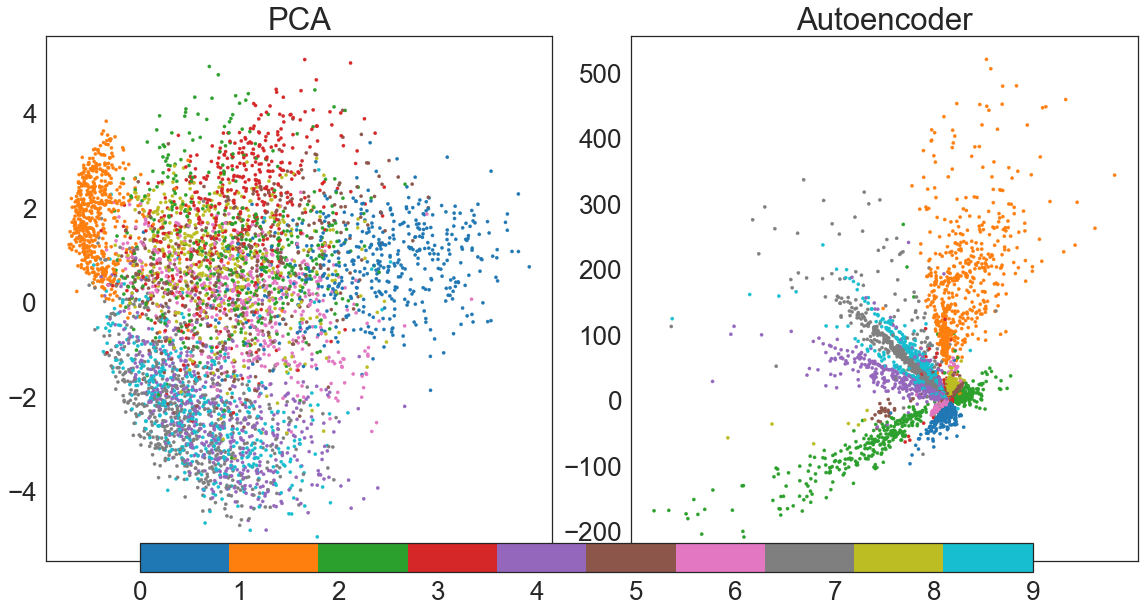

In [19]:
x_sample = x_train[:5000]
y_sample = y_train[:5000]
z_mu = model.encoder(x_sample)[0]

fig = plt.figure(figsize=(16, 8))
ax1 = plt.subplot(121)
ax1.set_title('PCA')
ax1.scatter(z_pca[:5000, 0], z_pca[:5000,1], c=y_train[:5000], s=10, cmap='tab10', alpha=1)

ax2 = plt.subplot(122)
s = ax2.scatter(z_mu[:, 0], z_mu[:, 1], c=y_sample, s=10, cmap='tab10', alpha=1)
ax2.set_title('Autoencoder')
#ax.grid()
#ax.set_aspect('equal')

#fig.subplots_adjust(bottom=0.85)

#ax.set_aspect('equal')
#cbar_ax = fig.add_axes([0.15, -.1, 0.7, 0.05])

#cb = fig.colorbar(s, cax=cbar_ax, orientation='horizontal')
p0 = ax1.get_position().get_points().flatten()
p1 = ax2.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0, p1[2]-p0[0], 0.05])
#fig.co
fig.colorbar(s, cax=ax_cbar, orientation='horizontal')
ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
fig.tight_layout()
fig.savefig('presentation_images/pca_autoencoder.png')

Populating the interactive namespace from numpy and matplotlib


/home/saket/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['interactive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


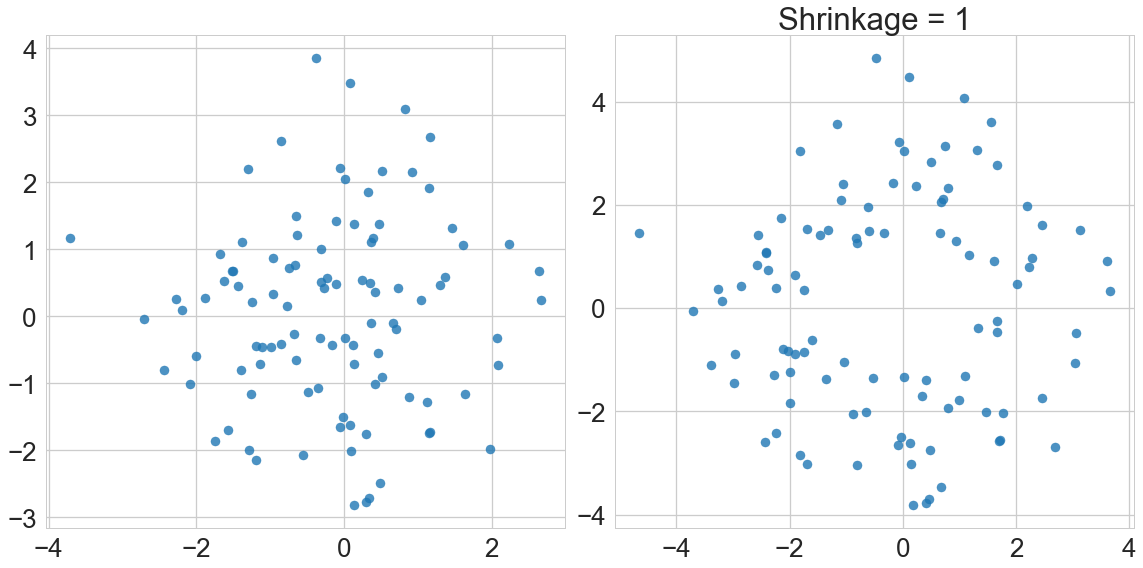

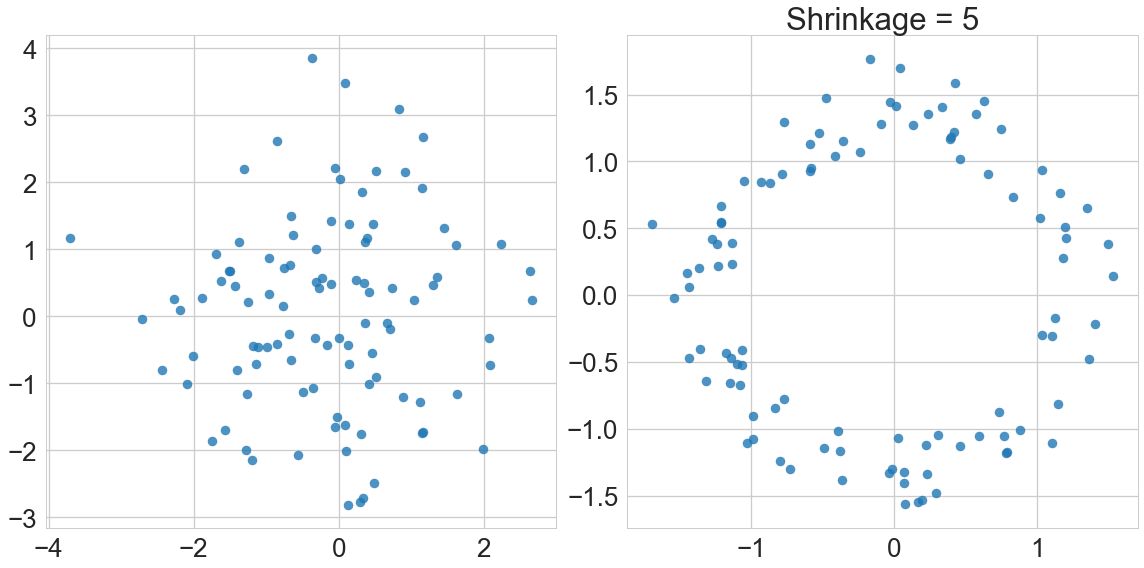

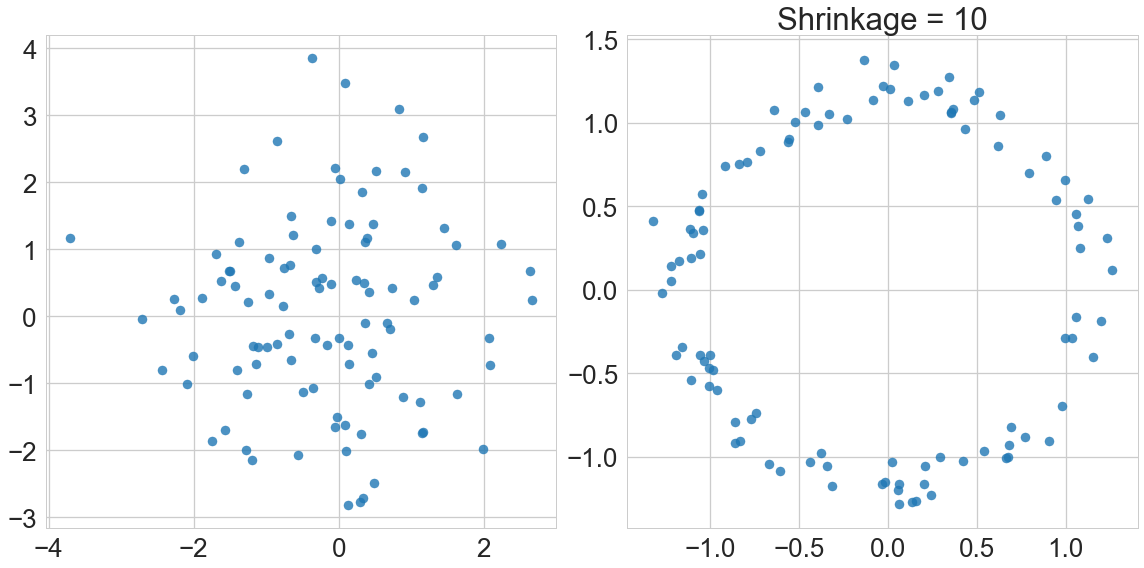

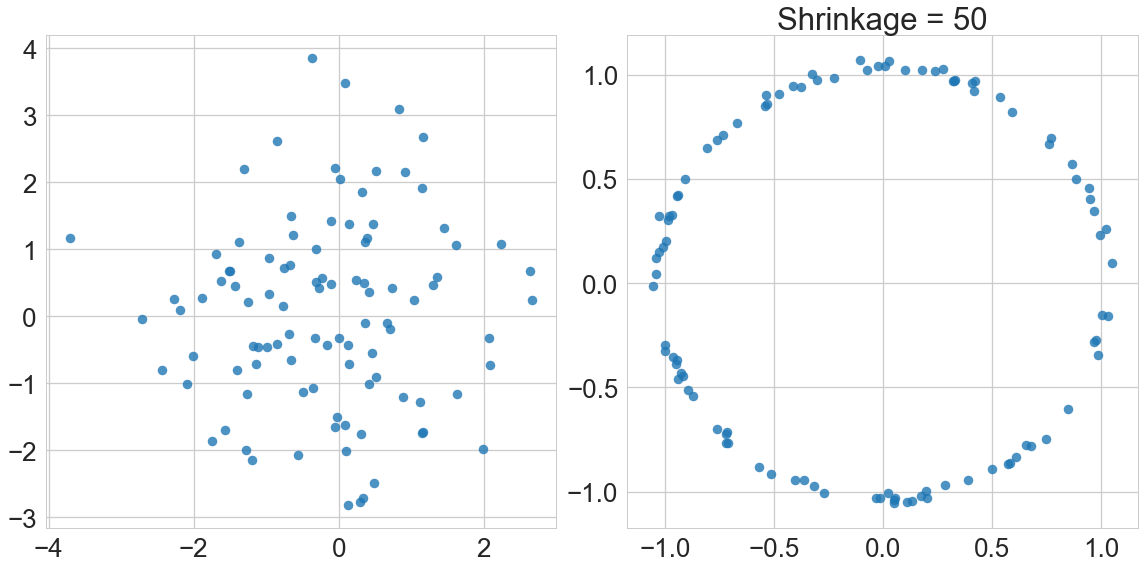

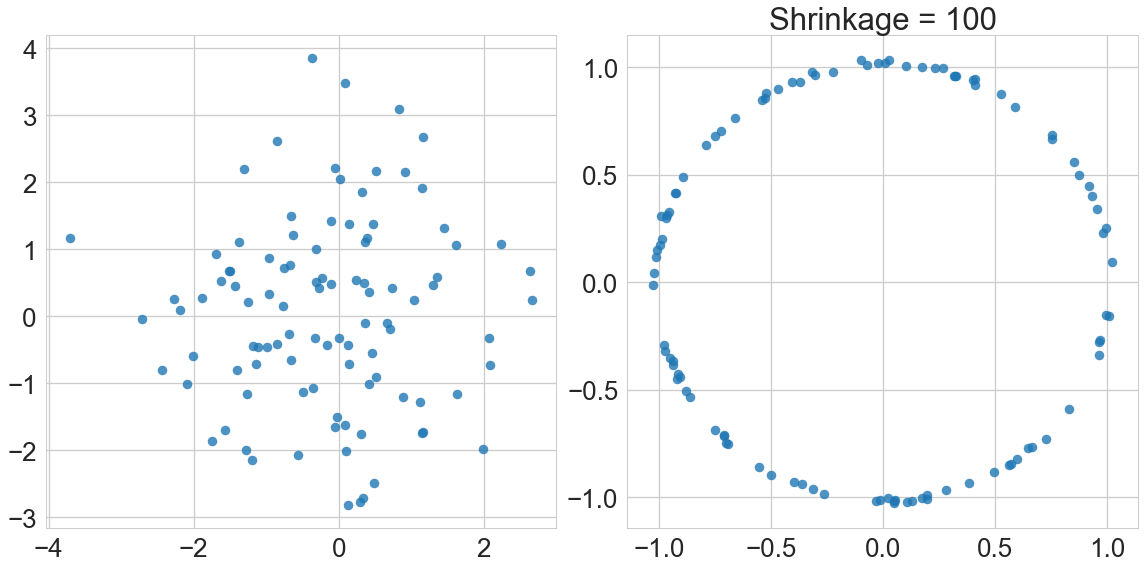

In [51]:
% pylab inline
from numpy import linalg as LA
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_gaussian(shrinkage):
    np.random.seed(42)
    mean = [0, 0]
    cov = [[2, 0], [0, 2]]

    fig = plt.figure(figsize=(16, 8))
    x = np.random.multivariate_normal(mean, cov, 100)
    y = x/shrinkage + x/LA.norm(x, 2, axis=1)[:, None]
    ax = plt.subplot(121)
    ax.scatter(x[:,0], x[:,1], alpha=0.8)
    ax = plt.subplot(122)
    ax.scatter(y[:,0], y[:,1], alpha=0.8)
    
    
#interact(plot_gaussian, shrinkage=widgets.IntSlider(min=1, max=300, step=1,value=1))
plot_gaussian(1)
plt.title('Shrinkage = 1')
plt.tight_layout()
plt.savefig('presentation_images/gaussian_one_shrinkage.pdf')

plot_gaussian(5)
plt.title('Shrinkage = 5')
plt.tight_layout()
plt.savefig('presentation_images/gaussian_five_shrinkage.pdf')

plot_gaussian(10)
plt.title('Shrinkage = 10')
plt.tight_layout()
plt.savefig('presentation_images/gaussian_ten_shrinkage.pdf')

plot_gaussian(50)
plt.title('Shrinkage = 50')
plt.tight_layout()
plt.savefig('presentation_images/gaussian_fifty_shrinkage.pdf')

plot_gaussian(100)
plt.title('Shrinkage = 100')
plt.tight_layout()
plt.savefig('presentation_images/gaussian_hundred_shrinkage.pdf')

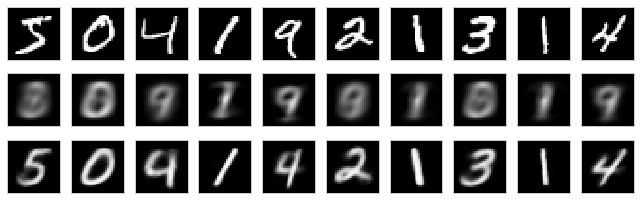

In [50]:
plt.figure(figsize=(9,3))
samples = (x_train, reconstructed_pca, reconstructed_autoencoder)
for i in range(10):
    for j in range(3):
        ax = plt.subplot(3, 10, 10*j+i+1)
        plt.imshow(samples[j][i,:].reshape(28,28), 
                   interpolation="nearest", 
                   vmin=0, vmax=1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig('presentation_images/pca_autoencoder_reconstruction.pdf')

# Kernel PCA

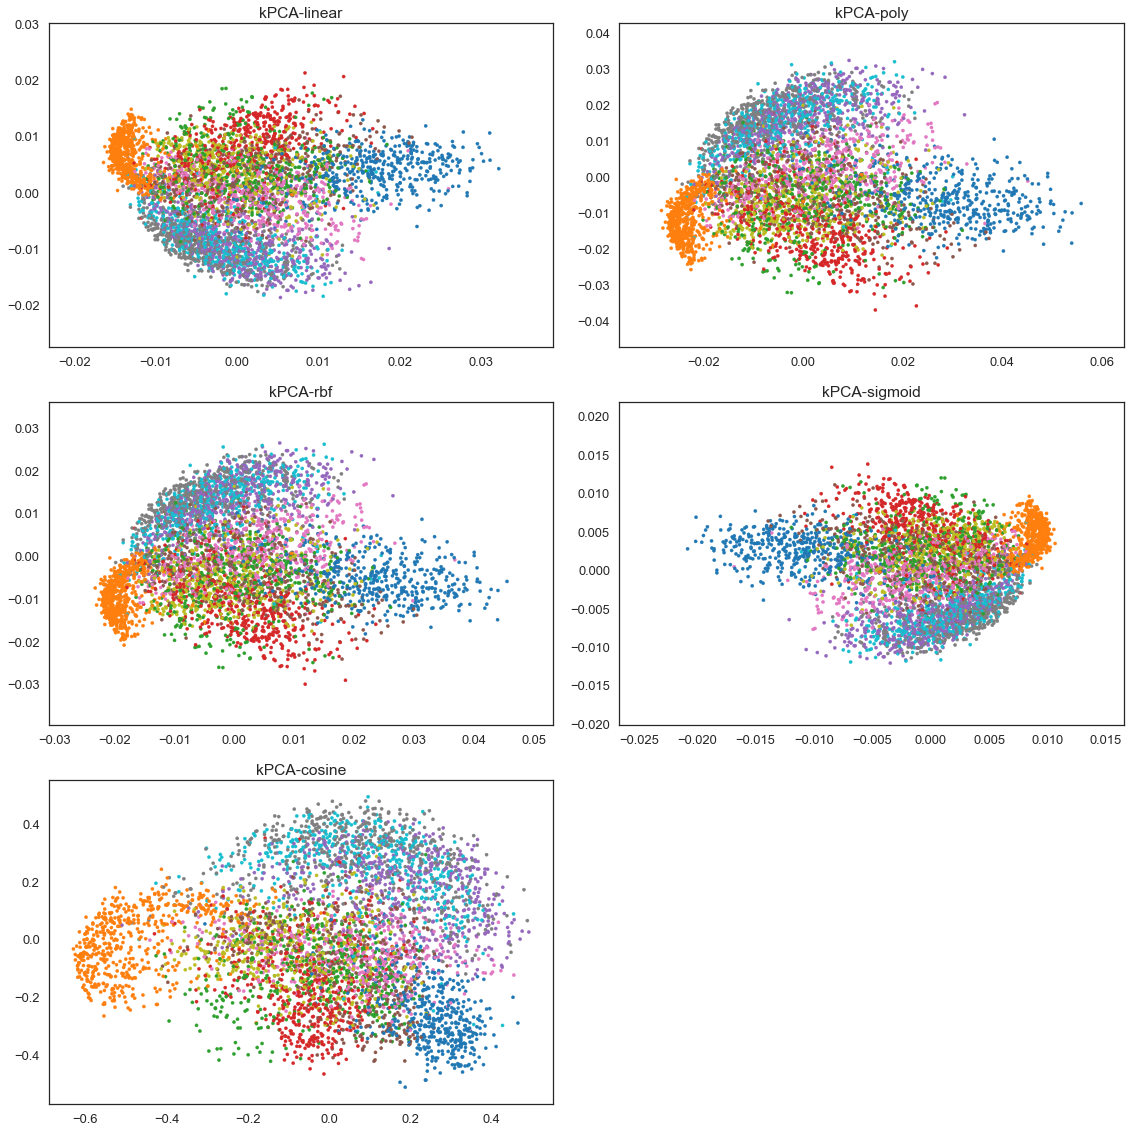

In [25]:
sns.set_context('talk', font_scale=2)
sns.set_style('white')
fig = plt.figure(figsize=(16, 16))
sns.set_context('talk')
index = 1
for kernel in ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']:

    kpca = KernelPCA(kernel=kernel, fit_inverse_transform=True, n_components=2, gamma=1)
    X_kpca = kpca.fit_transform(x_train[:5000,:]/255)
    X_back = kpca.inverse_transform(X_kpca)
    ax = plt.subplot(3,2, index)
    ax.set_title('kPCA-{}'.format(kernel))
    ax.scatter(X_kpca[:, 0], X_kpca[:,1], c=y_train[:5000], s=10, cmap='tab10', alpha=1)
    index+=1
fig.tight_layout()
fig.savefig('presentation_images/kPCA.pdf')

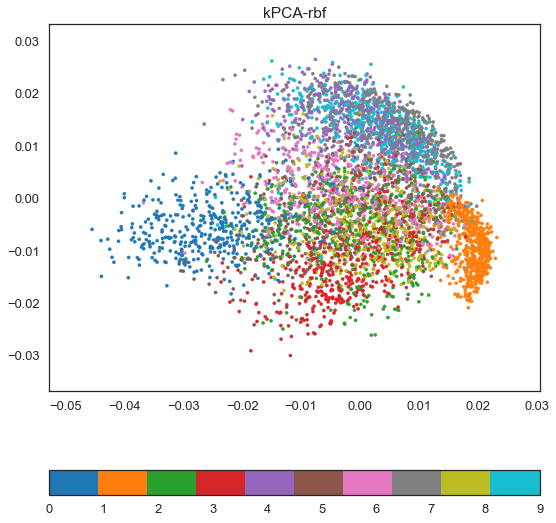

In [27]:
fig = plt.figure(figsize=(8, 8))
kernel = 'rbf'
kpca = KernelPCA(kernel=kernel, fit_inverse_transform=False, n_components=2, gamma=1)
X_kpca = kpca.fit_transform(x_train[:5000,:]/255)
ax = plt.subplot(111)
ax.set_title('kPCA-{}'.format(kernel))
s = ax.scatter(X_kpca[:, 0], X_kpca[:,1], c=y_train[:5000], s=10, cmap='tab10', alpha=1)
fig.colorbar(s, orientation='horizontal')
fig.tight_layout()
fig.savefig('presentation_images/kPCA_rbf.pdf')